In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load CSV
df = pd.read_csv("../recordings/pupil_hr_log.csv")

# Smooth the signal (optional)
df["pupil_radius"] = df["pupil_radius"].rolling(window=3, min_periods=1).mean()

# Create time series windows
def create_sequences(data, target, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(target[i+window_size])
    return np.array(X), np.array(y)

radius = df["pupil_radius"].values
hr = df["heart_rate"].values

# Normalize radius
scaler = MinMaxScaler()
radius = scaler.fit_transform(radius.reshape(-1, 1)).flatten()

X, y = create_sequences(radius, hr, window_size=30)
X = X[..., np.newaxis]  # Add channel dimension for CNN

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Dense, Flatten

model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(30, 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)  # Regression output
])

model.compile(
    optimizer='adam',
    loss=MeanSquaredError(),
    metrics=[MeanAbsoluteError()]
)
model.summary()


c:\Users\manit\anaconda3\envs\ml\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 28, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 14, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 12, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,041 (121.25 KB)

 Trainable params: 31,041 (121.25 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 4278.4834 - mean_absolute_error: 62.1377 - val_loss: 265.0138 - val_mean_absolute_error: 14.3663
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 180.8267 - mean_absolute_error: 11.5056 - val_loss: 68.9785 - val_mean_absolute_error: 7.1564
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 34.5067 - mean_absolute_error: 4.8098 - val_loss: 15.8969 - val_mean_absolute_error: 3.4305
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 21.1158 - mean_absolute_error: 3.6953 - val_loss: 23.6970 - val_mean_absolute_error: 4.3426
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 19.0006 - mean_absolute_error: 3.4794 - val_loss: 25.0652 - val_mean_absolute_error: 4.4591
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 18.8313 - mean_absolute_error: 3.4714 - val_loss: 27.3022 - val_mean_absolute_error: 4.7051
Epoch 7/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 18.1295 - mean_absolute_error: 3.43

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


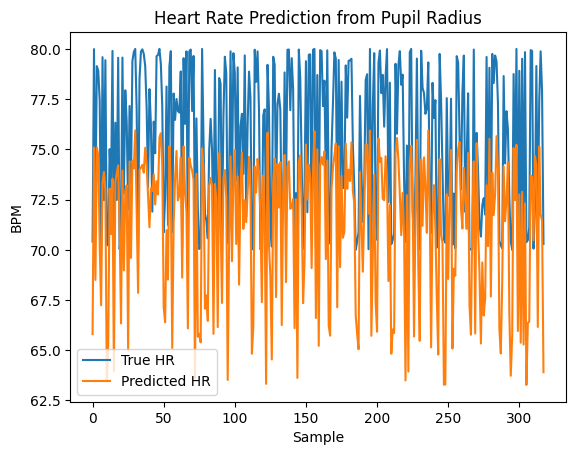

In [15]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test).flatten()

plt.plot(y_test, label="True HR")
plt.plot(y_pred, label="Predicted HR")
plt.legend()
plt.title("Heart Rate Prediction from Pupil Radius")
plt.xlabel("Sample")
plt.ylabel("BPM")
plt.show()


In [17]:
model.save("../models/cnn.h5")